<a href="https://colab.research.google.com/github/workhardzy/K6312/blob/main/preprocessing_COVID_news_ipynb%EF%BC%88for_topic_modeling%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the libraries needed

In [ ]:
#note you need to have it on your own google drive,for those who are sharing a drive, an approach is to add shortcut to your drive. 
#See https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab
#put in your authorisation code that is linked to the google account you are linking to and press enter
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#open file
import os
#import display
from IPython.display import display

import pandas as pd
import re, pickle, os
import datetime 
import nltk
from nltk.util import ngrams
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords, wordnet 
from collections import Counter 
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
from gensim.corpora import MmCorpus
from gensim.models.coherencemodel import CoherenceModel
#import pyLDAvis.gensim

import matplotlib.pyplot as plt
%matplotlib inline
import math
import ast
from tqdm.notebook import tqdm

pd.set_option('display.max_colwidth', -1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

text preprocessing

In [ ]:
additional_stop_words = ['marketscreener', 'sport express','co uk','news uk','world news','news guardian','uk news','express co','tv uk','showbiz tv','first quarter','second quarter','tv radio','news express','new yorker','motley fool','form k']                                                      ########调 (optional)
additional_stop_words = [words.lower() for words in additional_stop_words] #lowercasing the tokens

#classic understanding is to use nouns and verbs. see https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc
#ngram ordering also matters when cleaning data


def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"N": wordnet.NOUN,
                "V": wordnet.VERB,
                #"J": wordnet.ADJ, #classic understanding is to use nouns and verbs
                #"R": wordnet.ADV
               }

    return tag_dict.get(tag, wordnet.NOUN)

def text_cleanup(text):  
    '''
    Text pre-processing
        return tokenized list of cleaned words
    '''
    text = str(text)
    # Convert to lowercase
    text_clean = text.lower()
    # Remove non-alphabet
    text_clean = re.sub(r'[^a-zA-Z]|(\w+:\/\/\S+)',' ', text_clean).split()    
    # Remove short words (length < 3)
    #text_clean = [w for w in text_clean if len(w)>2]

    # Lemmatize text with the appropriate POS tag
    lemmatizer = WordNetLemmatizer()
    text_clean = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text_clean]
    # Filter out stop words in English 
    stops = set(stopwords.words('english')).union(additional_stop_words)
    text_clean = [w for w in text_clean if w not in stops]
    #joining the words together to remove bigram stopwords
    text_clean = ' '.join(text_clean)
    #remove bigram stopwords
    for stop in additional_stop_words:
        text_clean = text_clean.replace(stop, "")
    text_clean = text_clean.split()
    
    return text_clean

def preprocess_text(df,txt_col):
    # dataframe to add parsed tweets 
    cleaned_df = df.copy(deep=True)#what is this
    # parsing text 
    cleaned_df['token'] = [text_cleanup(x) for x in df[txt_col]]
    print('Start preprocessing tweets ...\n')
             
    # Save cleaned text to file
    return cleaned_df 

def save_checkpoint(df,filepath):
    df.to_pickle(filepath)
    print('saved dataframe at {}'.format(filepath)) 


In [ ]:
#testing
text = "China pneumonia outbreak: It's not SARS, so what is it? - tv uk news express co uk news sport uk CNN MarketScreener Express.co"
text_cleanup(text)

['china',
 'pneumonia',
 'outbreak',
 'sars',
 'tv',
 'express',
 'news',
 'sport',
 'uk',
 'cnn']

In [ ]:
#these are the functions to train the model

def save_print_to_file(outfile, msg):
    with open(outfile, 'w') as fp:
        print(msg, file=fp)  

def get_word_count(tweets_text, num_gram):
    '''
    Get common word counts
    '''
    n_grams = list(ngrams(tweets_text, num_gram))
    
    #stop_ngrams = ['local news']
    #n_grams = [i for i in n_grams if i not in stop_ngrams]
    
    common_words = Counter(n_grams).most_common()
    word_count = pd.DataFrame(data = common_words, 
                              columns=['word','frequency']) 
    # Convert list to string
    word_count['word'] = word_count['word'].apply(' '.join)
    # Plot word count graph
    word_count.head(20).sort_values('frequency').plot.barh(
            x='word', y='frequency', title='Word Frequency',figsize=(19,10))
    #plt.savefig(WORD_COUNT_FILE)
    #print ('Word count saved\n')
    #plt.close('all')
    
    return word_count

def word_grams(words, min=1, max=2):
    '''
    Build ngrams word list
    '''
    word_list = []
    for n in range(min, max):
        for ngram in ngrams(words, n):
            #print(ngram)
            word_list.append(' '.join(str(i) for i in ngram)) 
    return word_list

def train_lda_model(token_tweets):
    print('Start LDA model training ...\n')    
    # Build dictionary
    print('building dictionary')
    tweets_dict = corpora.Dictionary(token_tweets)
    # Remove words that occur less than 10 documents, # or more than 50% of the doc
    tweets_dict.filter_extremes(no_below=10, no_above=0.5)                       ########调
    # Transform doc to a vectorized form by computing frequency of each word
    bow_corpus = [tweets_dict.doc2bow(doc) for doc in token_tweets]
    # Save corpus and dictionary to file
    MmCorpus.serialize(CORPUS_FILE, bow_corpus)
    tweets_dict.save(DICT_FILE)
    print('saved corpus and dictionary to file')
    
    # Create tf-idf model and then apply transformation to the entire corpus
    print('create tf-idf model')
    tfidf = models.TfidfModel(bow_corpus)                                       ########调 (optional)
    tfidf_corpus = tfidf[bow_corpus]                                            ########调 (optional)
    
    print('training lda')
    # Train LDA model #this is the time bottleneck
    lda_model = models.ldamodel.LdaModel(corpus=tfidf_corpus,                   ########调 (optional)
                                         num_topics=NUM_TOPICS, 
                                         id2word=tweets_dict, 
                                         passes=NUM_PASSES, 
                                         alpha=ALPHA, 
                                         eta=ETA,
                                         random_state=42)
    # Save LDA model to file
    lda_model.save(LDA_MODEL_FILE)
    print ('LDA model saved\n')
      
    # Save all generated topics to a file
    msg = ''
    for idx, topic in lda_model.print_topics(-1):
        msg += 'Topic: {} \nWords: {}\n'.format(idx, topic)    
    save_print_to_file(LDA_TOPICS_FILE, msg)
    
    # Evaluate LDA model performance
    eval_lda (lda_model, tfidf_corpus, tweets_dict, token_tweets)    
    # Visualize topics
    vis_topics(lda_model, tfidf_corpus, tweets_dict)
        
    return lda_model

def eval_lda (lda_model, corpus, dict, token_text):
    
    # Compute Perplexity: a measure of how good the model is. lower the better.
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
    
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=token_text, 
                                         dictionary=dict, coherence='c_v')   
    print('\nCoherence: ', coherence_model_lda.get_coherence())

def vis_topics(lda_model, corpus, dict):
    '''
    Plot generated topics on an interactive graph
    '''
    lda_data =  pyLDAvis.gensim.prepare(lda_model, corpus, dict, mds='mmds')
    pyLDAvis.display(lda_data)
    pyLDAvis.save_html(lda_data, TOPIC_VIS_FILE)
    print ('Topic visual saved\n')

def wordcloud(word_count_df):
    '''
    Create word cloud image
    '''
    # Convert DataFrame to Map so that word cloud can be generated from freq
    word_count_dict = {}
    for w, f in word_count_df.values:
        word_count_dict[w] = f
    # Generate word cloud 
    wordcloud = WordCloud(max_words=300, width=1400, height=900, 
                          random_state=12, contour_width=3, 
                          contour_color='firebrick')
    wordcloud.generate_from_frequencies(word_count_dict)
    plt.figure(figsize=(10,10), facecolor='k')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    # Save the word cloud image
    #wordcloud.to_file(WORDCLOUD_FILE) 
    #print ('Word cloud saved\n')
    #plt.close('all')
    
    return wordcloud

In [ ]:
def clean_topics(df,col):
    print('CLEANING...')
    cleaned_tweets_df = preprocess_text(df,col) ########调
    return cleaned_tweets_df
    
def generate_ngrams(cleaned_tweets_df,NUM_GRAMS):
    # Convert series to list for word count
    print('creating tweets_text corpus')
    tweets_text = [word for one_tweet in cleaned_tweets_df['token'] for word in one_tweet]
    
    print('getting ngram word count')
    # Get common ngrams word count
    word_count_df = get_word_count(tweets_text, num_gram=NUM_GRAMS)
    
    # Generate word cloud
    tweets_wordcloud = wordcloud(word_count_df)  

    # Generate ngram tokens
    cleaned_tweets_df['ngram_token'] = [word_grams(x, NUM_GRAMS, NUM_GRAMS+1) for x in cleaned_tweets_df['token']]
    
    #cleaned_tweets_df.to_pickle('gdrive/My Drive/IO - twitter datasets/russia/preprocessed_IRA2016.h5')
    
    return cleaned_tweets_df

    
def trainingLDA(ngrams):
    print('TRAINING...')
    # Train LDA model and visualize generated topics
    lda_model = train_lda_model(ngrams)

    print('DONE!')
    
    return lda_model

Here we start training the model and the data

#can skip this part if text preprocessing is done
因为这个部分花很多时间

We have chosen to limit our analysis to news headlines

In [ ]:
lst = [
       #'/content/gdrive/My Drive/covid_mining/covid19_articles.csv',
       #'/content/gdrive/My Drive/covid_mining/covid19_articles_20200504.csv',
       #'/content/gdrive/My Drive/covid_mining/covid19_articles_20200512.csv',
       #'/content/gdrive/My Drive/covid_mining/covid19_articles_20200526.csv',
       #'/content/gdrive/My Drive/covid_mining/covid19_articles_20200726.csv',
       '/content/gdrive/My Drive/group/covid_data/covid19_articles_20200914.csv'
       ]

def concat_csv(lst):
    cncat = []
    for i in tqdm(range(len(lst))):
        df = pd.read_csv(lst[i],encoding='utf-8')
        #df = df.drop(['Unnamed: 0', 'author', 'domain', 'url','crawled_time'],axis=1).drop_duplicates()
        cncat.append(df)
    
    df = pd.concat(cncat)
    return df.drop(['Unnamed: 0', 'author', 'domain', 'url','crawled_time','content'],axis=1).drop_duplicates()
     

%time df = concat_csv(lst)
df


CPU times: user 21.8 s, sys: 2.4 s, total: 24.2 s
Wall time: 45.6 s


,title,date,topic_area
0,Three Industrial Giants You Should Own In 2020,2020-01-02,business
1,"Tesla (TSLA) Breaks Shipment Record, Beats Estimates for Fourth Quarter Vehicles Shipped",2020-01-03,business
2,Labor Stocks Are Going To Break Out In 2020,2020-01-03,business
3,Cal-Maine Just Shed 12% - But Is Now The Time To Buy,2020-01-06,business
4,"China pneumonia outbreak: It's not SARS, so what is it? - CNN",2020-01-06,business
...,...,...,...
290474,"Trump signs new, expanded executive order to lower U.S. drug prices",2020-09-14,business
290475,Nuggets force Game 7 and D'Antoni leaves HOU,2020-09-14,business
290476,Health Official Out To Manipulate CDC Reports Has Deep Russian Ties,2020-09-14,business
290477,Global Markets: Asian shares buoyed by coronavirus vaccine hopes,2020-09-14,business


In [ ]:
df.columns

Index(['title', 'date', 'topic_area'], dtype='object')

In [ ]:
pd.set_option('display.max_colwidth', -1)
#df['text'] = df['title'] + ' '+  df['content']
df 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,title,date,topic_area
0,Three Industrial Giants You Should Own In 2020,2020-01-02,business
1,"Tesla (TSLA) Breaks Shipment Record, Beats Estimates for Fourth Quarter Vehicles Shipped",2020-01-03,business
2,Labor Stocks Are Going To Break Out In 2020,2020-01-03,business
3,Cal-Maine Just Shed 12% - But Is Now The Time To Buy,2020-01-06,business
4,"China pneumonia outbreak: It's not SARS, so what is it? - CNN",2020-01-06,business
...,...,...,...
290474,"Trump signs new, expanded executive order to lower U.S. drug prices",2020-09-14,business
290475,Nuggets force Game 7 and D'Antoni leaves HOU,2020-09-14,business
290476,Health Official Out To Manipulate CDC Reports Has Deep Russian Ties,2020-09-14,business
290477,Global Markets: Asian shares buoyed by coronavirus vaccine hopes,2020-09-14,business


In [ ]:
#text preprocessing and ngrams generation
%time df = clean_topics(df,'title') #this takes a long time, if there is the preprocessed_news.h5 file, use that
save_checkpoint(df,'/content/gdrive/My Drive/group/data/preprocessed_news_headlines.h5') ########调 

CLEANING...
Start preprocessing tweets ...

CPU times: user 9min 40s, sys: 32.8 s, total: 10min 13s
Wall time: 10min 13s
saved dataframe at /content/gdrive/My Drive/group/data/preprocessed_news_headlines.h5


creating tweets_text corpus
getting ngram word count


,title,date,topic_area,token,ngram_token
0,Three Industrial Giants You Should Own In 2020,2020-01-02,business,"[three, industrial, giant]","[three industrial, industrial giant]"
1,"Tesla (TSLA) Breaks Shipment Record, Beats Estimates for Fourth Quarter Vehicles Shipped",2020-01-03,business,"[tesla, tsla, break, shipment, record, beat, estimate, fourth, quarter, vehicle, ship]","[tesla tsla, tsla break, break shipment, shipment record, record beat, beat estimate, estimate fourth, fourth quarter, quarter vehicle, vehicle ship]"
2,Labor Stocks Are Going To Break Out In 2020,2020-01-03,business,"[labor, stock, go, break]","[labor stock, stock go, go break]"
3,Cal-Maine Just Shed 12% - But Is Now The Time To Buy,2020-01-06,business,"[cal, maine, shed, time, buy]","[cal maine, maine shed, shed time, time buy]"
4,"China pneumonia outbreak: It's not SARS, so what is it? - CNN",2020-01-06,business,"[china, pneumonia, outbreak, sars, cnn]","[china pneumonia, pneumonia outbreak, outbreak sars, sars cnn]"
...,...,...,...,...,...
290474,"Trump signs new, expanded executive order to lower U.S. drug prices",2020-09-14,business,"[trump, sign, new, expand, executive, order, lower, u, drug, price]","[trump sign, sign new, new expand, expand executive, executive order, order lower, lower u, u drug, drug price]"
290475,Nuggets force Game 7 and D'Antoni leaves HOU,2020-09-14,business,"[nugget, force, game, antoni, leaf, hou]","[nugget force, force game, game antoni, antoni leaf, leaf hou]"
290476,Health Official Out To Manipulate CDC Reports Has Deep Russian Ties,2020-09-14,business,"[health, official, manipulate, cdc, report, deep, russian, tie]","[health official, official manipulate, manipulate cdc, cdc report, report deep, deep russian, russian tie]"
290477,Global Markets: Asian shares buoyed by coronavirus vaccine hopes,2020-09-14,business,"[global, market, asian, share, buoyed, coronavirus, vaccine, hope]","[global market, market asian, asian share, share buoyed, buoyed coronavirus, coronavirus vaccine, vaccine hope]"


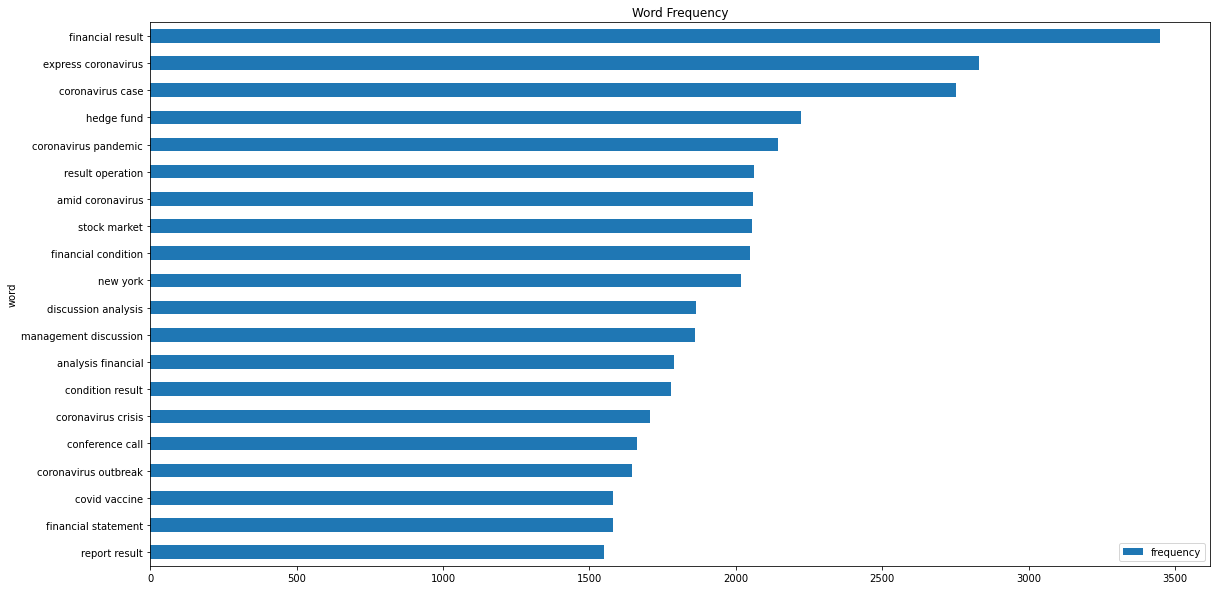

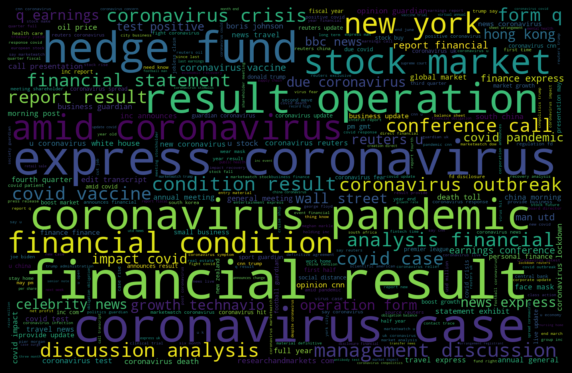

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

df = pd.read_pickle('/content/gdrive/My Drive/group/data/preprocessed_news_headlines.h5') ########调
df = generate_ngrams(df,NUM_GRAMS=2) #NUM_GRAMS is bad convention, but I am not changing it due to practical reasons
df

In [ ]:
df

,title,date,topic_area,token,ngram_token
0,Three Industrial Giants You Should Own In 2020,2020-01-02,business,"[three, industrial, giant]","[three industrial, industrial giant]"
1,"Tesla (TSLA) Breaks Shipment Record, Beats Estimates for Fourth Quarter Vehicles Shipped",2020-01-03,business,"[tesla, tsla, break, shipment, record, beat, estimate, fourth, quarter, vehicle, ship]","[tesla tsla, tsla break, break shipment, shipment record, record beat, beat estimate, estimate fourth, fourth quarter, quarter vehicle, vehicle ship]"
2,Labor Stocks Are Going To Break Out In 2020,2020-01-03,business,"[labor, stock, go, break]","[labor stock, stock go, go break]"
3,Cal-Maine Just Shed 12% - But Is Now The Time To Buy,2020-01-06,business,"[cal, maine, shed, time, buy]","[cal maine, maine shed, shed time, time buy]"
4,"China pneumonia outbreak: It's not SARS, so what is it? - CNN",2020-01-06,business,"[china, pneumonia, outbreak, sars, cnn]","[china pneumonia, pneumonia outbreak, outbreak sars, sars cnn]"
...,...,...,...,...,...
290474,"Trump signs new, expanded executive order to lower U.S. drug prices",2020-09-14,business,"[trump, sign, new, expand, executive, order, lower, u, drug, price]","[trump sign, sign new, new expand, expand executive, executive order, order lower, lower u, u drug, drug price]"
290475,Nuggets force Game 7 and D'Antoni leaves HOU,2020-09-14,business,"[nugget, force, game, antoni, leaf, hou]","[nugget force, force game, game antoni, antoni leaf, leaf hou]"
290476,Health Official Out To Manipulate CDC Reports Has Deep Russian Ties,2020-09-14,business,"[health, official, manipulate, cdc, report, deep, russian, tie]","[health official, official manipulate, manipulate cdc, cdc report, report deep, deep russian, russian tie]"
290477,Global Markets: Asian shares buoyed by coronavirus vaccine hopes,2020-09-14,business,"[global, market, asian, share, buoyed, coronavirus, vaccine, hope]","[global market, market asian, asian share, share buoyed, buoyed coronavirus, coronavirus vaccine, vaccine hope]"


In [ ]:
save_checkpoint(df,'/content/gdrive/My Drive/group/data/preprocessed_news_headlines.h5') ########调

saved dataframe at /content/gdrive/My Drive/group/data/preprocessed_news_headlines.h5


In [ ]:
#run this when you want to skip preprocessing
df = pd.read_pickle('/content/gdrive/My Drive/group/data/preprocessed_news_headlines.h5') ########调 
df

,title,date,topic_area,token,ngram_token
0,Three Industrial Giants You Should Own In 2020,2020-01-02,business,"[three, industrial, giant]","[three industrial, industrial giant]"
1,"Tesla (TSLA) Breaks Shipment Record, Beats Estimates for Fourth Quarter Vehicles Shipped",2020-01-03,business,"[tesla, tsla, break, shipment, record, beat, estimate, fourth, quarter, vehicle, ship]","[tesla tsla, tsla break, break shipment, shipment record, record beat, beat estimate, estimate fourth, fourth quarter, quarter vehicle, vehicle ship]"
2,Labor Stocks Are Going To Break Out In 2020,2020-01-03,business,"[labor, stock, go, break]","[labor stock, stock go, go break]"
3,Cal-Maine Just Shed 12% - But Is Now The Time To Buy,2020-01-06,business,"[cal, maine, shed, time, buy]","[cal maine, maine shed, shed time, time buy]"
4,"China pneumonia outbreak: It's not SARS, so what is it? - CNN",2020-01-06,business,"[china, pneumonia, outbreak, sars, cnn]","[china pneumonia, pneumonia outbreak, outbreak sars, sars cnn]"
...,...,...,...,...,...
290474,"Trump signs new, expanded executive order to lower U.S. drug prices",2020-09-14,business,"[trump, sign, new, expand, executive, order, lower, u, drug, price]","[trump sign, sign new, new expand, expand executive, executive order, order lower, lower u, u drug, drug price]"
290475,Nuggets force Game 7 and D'Antoni leaves HOU,2020-09-14,business,"[nugget, force, game, antoni, leaf, hou]","[nugget force, force game, game antoni, antoni leaf, leaf hou]"
290476,Health Official Out To Manipulate CDC Reports Has Deep Russian Ties,2020-09-14,business,"[health, official, manipulate, cdc, report, deep, russian, tie]","[health official, official manipulate, manipulate cdc, cdc report, report deep, deep russian, russian tie]"
290477,Global Markets: Asian shares buoyed by coronavirus vaccine hopes,2020-09-14,business,"[global, market, asian, share, buoyed, coronavirus, vaccine, hope]","[global market, market asian, asian share, share buoyed, buoyed coronavirus, coronavirus vaccine, vaccine hope]"


In [ ]:
#check if the word is in the title
df[df['title'].str.contains('MarketScreener')]




,title,date,topic_area,token,ngram_token
62,"Southeast Asia stocks: Singapore falls on China virus fears, Philippines extends losses | MarketScreener",2020-01-20,business,"[southeast, asia, stock, singapore, fall, china, virus, fear, philippine, extends, loss]","[southeast asia, asia stock, stock singapore, singapore fall, fall china, china virus, virus fear, fear philippine, philippine extends, extends loss]"
90,Virus outbreak prompts Chinese travel firms to offer free cancellations | MarketScreener,2020-01-21,business,"[virus, outbreak, prompt, chinese, travel, firm, offer, free, cancellation]","[virus outbreak, outbreak prompt, prompt chinese, chinese travel, travel firm, firm offer, offer free, free cancellation]"
92,"China Eastern Airlines Down Over 10%, on Pace for Largest Percent Decrease Since August 2015 -- Data Talk | MarketScreener",2020-01-21,business,"[china, eastern, airline, pace, largest, percent, decrease, since, august, data, talk]","[china eastern, eastern airline, airline pace, pace largest, largest percent, percent decrease, decrease since, since august, august data, data talk]"
115,"European Luxury, Airline Stocks Suffer Blow Amid Chinese Outbreak -- 2nd Update | MarketScreener",2020-01-21,business,"[european, luxury, airline, stock, suffer, blow, amid, chinese, outbreak, nd, update]","[european luxury, luxury airline, airline stock, stock suffer, suffer blow, blow amid, amid chinese, chinese outbreak, outbreak nd, nd update]"
134,China virus scare sends shudder through European luxury goods sector | MarketScreener,2020-01-21,business,"[china, virus, scare, sends, shudder, european, luxury, good, sector]","[china virus, virus scare, scare sends, sends shudder, shudder european, european luxury, luxury good, good sector]"
...,...,...,...,...,...
290331,"Pound dogged by Brexit worries, yen looks to Abe successor vote | MarketScreener",2020-09-14,business,"[pound, dog, brexit, worry, yen, look, abe, successor, vote]","[pound dog, dog brexit, brexit worry, worry yen, yen look, look abe, abe successor, successor vote]"
290332,AFC : Director nominations & virtual-only 2020 AGM date | MarketScreener,2020-09-14,business,"[afc, director, nomination, virtual, agm, date]","[afc director, director nomination, nomination virtual, virtual agm, agm date]"
290333,Bidvest : 14th September 2020 - Bidvest FY20 results; Chief Executive retirement and appointment | MarketScreener,2020-09-14,business,"[bidvest, th, september, bidvest, fy, result, chief, executive, retirement, appointment]","[bidvest th, th september, september bidvest, bidvest fy, fy result, result chief, chief executive, executive retirement, retirement appointment]"
290335,Portfolio Company Update: Guident | MarketScreener,2020-09-14,business,"[portfolio, company, update, guident]","[portfolio company, company update, update guident]"


In [ ]:
df = pd.read_pickle('/content/gdrive/My Drive/group/data/preprocessed_news_headlines.h5') ########调 
df
df['ngram_join'] = df['ngram_token'].apply(lambda x:' '.join(x))
df[df['ngram_join'].str.contains('result operation')]

,title,date,topic_area,token,ngram_token,ngram_join
2802,QUALCOMM IN : DE MANAGEMENT'S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS (form 10-Q) | MarketScreener,2020-02-05,business,"[qualcomm, de, management, discussion, analysis, financial, condition, result, operation, form, q]","[qualcomm de, de management, management discussion, discussion analysis, analysis financial, financial condition, condition result, result operation, operation form, form q]",qualcomm de de management management discussion discussion analysis analysis financial financial condition condition result result operation operation form form q
3013,CELANESE : Management's Discussion and Analysis of Financial Condition and Results of Operations (form 10-K) | MarketScreener,2020-02-06,business,"[celanese, management, discussion, analysis, financial, condition, result, operation]","[celanese management, management discussion, discussion analysis, analysis financial, financial condition, condition result, result operation]",celanese management management discussion discussion analysis analysis financial financial condition condition result result operation
6073,BAUSCH HEALTH : Management's Discussion and Analysis of Financial Condition and Results of Operations (form 10-K) | MarketScreener,2020-02-19,business,"[bausch, health, management, discussion, analysis, financial, condition, result, operation]","[bausch health, health management, management discussion, discussion analysis, analysis financial, financial condition, condition result, result operation]",bausch health health management management discussion discussion analysis analysis financial financial condition condition result result operation
7462,AVANOS MEDICAL : MANAGEMENT'S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS (form 10-K) | MarketScreener,2020-02-25,business,"[avanos, medical, management, discussion, analysis, financial, condition, result, operation]","[avanos medical, medical management, management discussion, discussion analysis, analysis financial, financial condition, condition result, result operation]",avanos medical medical management management discussion discussion analysis analysis financial financial condition condition result result operation
7689,PENTAIR : MANAGEMENT'S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS (form 10-K) | MarketScreener,2020-02-25,business,"[pentair, management, discussion, analysis, financial, condition, result, operation]","[pentair management, management discussion, discussion analysis, analysis financial, financial condition, condition result, result operation]",pentair management management discussion discussion analysis analysis financial financial condition condition result result operation
...,...,...,...,...,...,...
288642,EGAIN : MANAGEMENT'S DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS (form 10-K) | MarketScreener,2020-09-11,business,"[egain, management, discussion, analysis, financial, condition, result, operation]","[egain management, management discussion, discussion analysis, analysis financial, financial condition, condition result, result operation]",egain management management discussion discussion analysis analysis financial financial condition condition result result operation
288662,HIGHWATER ETHANOL LLC : Management's Discussion and Analysis of Financial Condition and Results of Operations (form 10-Q) | MarketScreener,2020-09-11,business,"[highwater, ethanol, llc, management, discussion, analysis, financial, condition, result, operation, form, q]","[highwater ethanol, ethanol llc, llc management, management discussion, discussion analysis, analysis financial, financial condition, condition result, result operation, operation form, form q]",highwater ethanol ethanol llc llc management management discussion discussion analysis analysis financial financial condition condition result result operation operation form form q
288747,1

#to cut the data by month

In [ ]:
df = pd.read_pickle('/content/gdrive/My Drive/group/data/preprocessed_news_headlines.h5') ########调 
df

,title,date,topic_area,token,ngram_token
0,Three Industrial Giants You Should Own In 2020,2020-01-02,business,"[three, industrial, giant]","[three industrial, industrial giant]"
1,"Tesla (TSLA) Breaks Shipment Record, Beats Estimates for Fourth Quarter Vehicles Shipped",2020-01-03,business,"[tesla, tsla, break, shipment, record, beat, estimate, fourth, quarter, vehicle, ship]","[tesla tsla, tsla break, break shipment, shipment record, record beat, beat estimate, estimate fourth, fourth quarter, quarter vehicle, vehicle ship]"
2,Labor Stocks Are Going To Break Out In 2020,2020-01-03,business,"[labor, stock, go, break]","[labor stock, stock go, go break]"
3,Cal-Maine Just Shed 12% - But Is Now The Time To Buy,2020-01-06,business,"[cal, maine, shed, time, buy]","[cal maine, maine shed, shed time, time buy]"
4,"China pneumonia outbreak: It's not SARS, so what is it? - CNN",2020-01-06,business,"[china, pneumonia, outbreak, sars, cnn]","[china pneumonia, pneumonia outbreak, outbreak sars, sars cnn]"
...,...,...,...,...,...
290474,"Trump signs new, expanded executive order to lower U.S. drug prices",2020-09-14,business,"[trump, sign, new, expand, executive, order, lower, u, drug, price]","[trump sign, sign new, new expand, expand executive, executive order, order lower, lower u, u drug, drug price]"
290475,Nuggets force Game 7 and D'Antoni leaves HOU,2020-09-14,business,"[nugget, force, game, antoni, leaf, hou]","[nugget force, force game, game antoni, antoni leaf, leaf hou]"
290476,Health Official Out To Manipulate CDC Reports Has Deep Russian Ties,2020-09-14,business,"[health, official, manipulate, cdc, report, deep, russian, tie]","[health official, official manipulate, manipulate cdc, cdc report, report deep, deep russian, russian tie]"
290477,Global Markets: Asian shares buoyed by coronavirus vaccine hopes,2020-09-14,business,"[global, market, asian, share, buoyed, coronavirus, vaccine, hope]","[global market, market asian, asian share, share buoyed, buoyed coronavirus, coronavirus vaccine, vaccine hope]"


In [ ]:
#df['date'] = df['date'].to_datetime()

df.date = pd.to_datetime(df.date)


In [ ]:
df['month'] = df['date'].dt.month

In [ ]:
df

,title,date,topic_area,token,ngram_token,month
0,Three Industrial Giants You Should Own In 2020,2020-01-02,business,"[three, industrial, giant]","[three industrial, industrial giant]",1
1,"Tesla (TSLA) Breaks Shipment Record, Beats Estimates for Fourth Quarter Vehicles Shipped",2020-01-03,business,"[tesla, tsla, break, shipment, record, beat, estimate, fourth, quarter, vehicle, ship]","[tesla tsla, tsla break, break shipment, shipment record, record beat, beat estimate, estimate fourth, fourth quarter, quarter vehicle, vehicle ship]",1
2,Labor Stocks Are Going To Break Out In 2020,2020-01-03,business,"[labor, stock, go, break]","[labor stock, stock go, go break]",1
3,Cal-Maine Just Shed 12% - But Is Now The Time To Buy,2020-01-06,business,"[cal, maine, shed, time, buy]","[cal maine, maine shed, shed time, time buy]",1
4,"China pneumonia outbreak: It's not SARS, so what is it? - CNN",2020-01-06,business,"[china, pneumonia, outbreak, sars, cnn]","[china pneumonia, pneumonia outbreak, outbreak sars, sars cnn]",1
...,...,...,...,...,...,...
290474,"Trump signs new, expanded executive order to lower U.S. drug prices",2020-09-14,business,"[trump, sign, new, expand, executive, order, lower, u, drug, price]","[trump sign, sign new, new expand, expand executive, executive order, order lower, lower u, u drug, drug price]",9
290475,Nuggets force Game 7 and D'Antoni leaves HOU,2020-09-14,business,"[nugget, force, game, antoni, leaf, hou]","[nugget force, force game, game antoni, antoni leaf, leaf hou]",9
290476,Health Official Out To Manipulate CDC Reports Has Deep Russian Ties,2020-09-14,business,"[health, official, manipulate, cdc, report, deep, russian, tie]","[health official, official manipulate, manipulate cdc, cdc report, report deep, deep russian, russian tie]",9
290477,Global Markets: Asian shares buoyed by coronavirus vaccine hopes,2020-09-14,business,"[global, market, asian, share, buoyed, coronavirus, vaccine, hope]","[global market, market asian, asian share, share buoyed, buoyed coronavirus, coronavirus vaccine, vaccine hope]",9


In [ ]:
max(df['month'])

9

In [ ]:
for i in range(max(df['month'])+1):
    display(df[df['month']==i])
    _ = df[df['month']==i]

    save_checkpoint(_,'/content/gdrive/My Drive/group/data/preprocessed_news_headlines{}.h5'.format(i)) ########调

,title,date,topic_area,token,ngram_token,month


saved dataframe at /content/gdrive/My Drive/group/data/preprocessed_news_headlines0.h5


,title,date,topic_area,token,ngram_token,month
0,Three Industrial Giants You Should Own In 2020,2020-01-02,business,"[three, industrial, giant]","[three industrial, industrial giant]",1
1,"Tesla (TSLA) Breaks Shipment Record, Beats Estimates for Fourth Quarter Vehicles Shipped",2020-01-03,business,"[tesla, tsla, break, shipment, record, beat, estimate, fourth, quarter, vehicle, ship]","[tesla tsla, tsla break, break shipment, shipment record, record beat, beat estimate, estimate fourth, fourth quarter, quarter vehicle, vehicle ship]",1
2,Labor Stocks Are Going To Break Out In 2020,2020-01-03,business,"[labor, stock, go, break]","[labor stock, stock go, go break]",1
3,Cal-Maine Just Shed 12% - But Is Now The Time To Buy,2020-01-06,business,"[cal, maine, shed, time, buy]","[cal maine, maine shed, shed time, time buy]",1
4,"China pneumonia outbreak: It's not SARS, so what is it? - CNN",2020-01-06,business,"[china, pneumonia, outbreak, sars, cnn]","[china pneumonia, pneumonia outbreak, outbreak sars, sars cnn]",1
...,...,...,...,...,...,...
1948,"Fake coronavirus cures and other misinformation taken down by Facebook, Google and Twitter - CNN",2020-01-31,general,"[fake, coronavirus, cure, misinformation, take, facebook, google, twitter, cnn]","[fake coronavirus, coronavirus cure, cure misinformation, misinformation take, take facebook, facebook google, google twitter, twitter cnn]",1
1949,Travel ban expanded to six new countries - CNNPolitics,2020-01-31,general,"[travel, ban, expand, six, new, country, cnnpolitics]","[travel ban, ban expand, expand six, six new, new country, country cnnpolitics]",1
1950,Goldman Sachs warns that the coronavirus could slow the US economy - CNN,2020-01-31,general,"[goldman, sachs, warns, coronavirus, could, slow, u, economy, cnn]","[goldman sachs, sachs warns, warns coronavirus, coronavirus could, could slow, slow u, u economy, economy cnn]",1
1951,Jim Carrey health latest: Actor discusses depression - symptoms and signs | Express.co.uk,2020-01-31,general,"[jim, carrey, health, latest, actor, discus, depression, symptom, sign, express]","[jim carrey, carrey health, health latest, latest actor, actor discus, discus depression, depression symptom, symptom sign, sign express]",1


saved dataframe at /content/gdrive/My Drive/group/data/preprocessed_news_headlines1.h5


,title,date,topic_area,token,ngram_token,month
1953,Eighth US case of new coronavirus confirmed in Massachussetts,2020-02-01,finance,"[eighth, u, case, new, coronavirus, confirm, massachussetts]","[eighth u, u case, case new, new coronavirus, coronavirus confirm, confirm massachussetts]",2
1954,"Japan seeks to contain economic impact of virus, new measures come into effect",2020-02-01,business,"[japan, seek, contain, economic, impact, virus, new, measure, come, effect]","[japan seek, seek contain, contain economic, economic impact, impact virus, virus new, new measure, measure come, come effect]",2
1955,"Coronavirus just starting to have an impact on global economy, geopolitics",2020-02-01,finance,"[coronavirus, start, impact, global, economy, geopolitics]","[coronavirus start, start impact, impact global, global economy, economy geopolitics]",2
1956,"India announces $40 billion spending on farms, tax cuts to revive faltering growth | MarketScreener",2020-02-01,business,"[india, announces, billion, spending, farm, tax, cut, revive, falter, growth]","[india announces, announces billion, billion spending, spending farm, farm tax, tax cut, cut revive, revive falter, falter growth]",2
1957,India's govt to spend $40 billion on farm sector to lift wobbly economy; fiscal deficit slips,2020-02-01,business,"[india, govt, spend, billion, farm, sector, lift, wobbly, economy, fiscal, deficit, slip]","[india govt, govt spend, spend billion, billion farm, farm sector, sector lift, lift wobbly, wobbly economy, economy fiscal, fiscal deficit, deficit slip]",2
...,...,...,...,...,...,...
9709,"Automakes scramble for parts, prepare war rooms as coronavirus spreads",2020-02-29,finance,"[automakes, scramble, part, prepare, war, room, coronavirus, spread]","[automakes scramble, scramble part, part prepare, prepare war, war room, room coronavirus, coronavirus spread]",2
9710,US postpones summit with ASEAN leaders amid coronavirus fears: Sources,2020-02-29,finance,"[u, postpones, summit, asean, leader, amid, coronavirus, fear, source]","[u postpones, postpones summit, summit asean, asean leader, leader amid, amid coronavirus, coronavirus fear, fear source]",2
9711,Washington state confirms first US death from coronavirus,2020-02-29,finance,"[washington, state, confirms, first, u, death, coronavirus]","[washington state, state confirms, confirms first, first u, u death, death coronavirus]",2
9712,Trump says the coronavirus is Democrats' new 'hoax',2020-02-29,finance,"[trump, say, coronavirus, democrat, new, hoax]","[trump say, say coronavirus, coronavirus democrat, democrat new, new hoax]",2


saved dataframe at /content/gdrive/My Drive/group/data/preprocessed_news_headlines2.h5


,title,date,topic_area,token,ngram_token,month
9714,"UPDATE 1-Iran's death toll from coronavirus jumps to 54, with 978 infected",2020-03-01,finance,"[update, iran, death, toll, coronavirus, jump, infect]","[update iran, iran death, death toll, toll coronavirus, coronavirus jump, jump infect]",3
9715,Surgeon general wants you to stop buying masks to protect yourself from coronavirus: ‘They are NOT effective’ - MarketWatch,2020-03-01,business,"[surgeon, general, want, stop, buying, mask, protect, coronavirus, effective, marketwatch]","[surgeon general, general want, want stop, stop buying, buying mask, mask protect, protect coronavirus, coronavirus effective, effective marketwatch]",3
9716,"Costco, Target, Zoom Video, and Other Stocks for Investors to Watch This Week - MarketWatch",2020-03-01,business,"[costco, target, zoom, video, stock, investor, watch, week, marketwatch]","[costco target, target zoom, zoom video, video stock, stock investor, investor watch, watch week, week marketwatch]",3
9717,"Washington state: Two dead, 13 positive cases of coronavirus - CNN",2020-03-01,general,"[washington, state, two, dead, positive, case, coronavirus, cnn]","[washington state, state two, two dead, dead positive, positive case, case coronavirus, coronavirus cnn]",3
9718,"Elon Musk, Larry Ellison Bought Tesla. Then Coronavirus Hit Stocks. - MarketWatch",2020-03-01,business,"[elon, musk, larry, ellison, bought, tesla, coronavirus, hit, stock, marketwatch]","[elon musk, musk larry, larry ellison, ellison bought, bought tesla, tesla coronavirus, coronavirus hit, hit stock, stock marketwatch]",3
...,...,...,...,...,...,...
50048,Select Energy Services : Provides Operational Updates And Strategic Actions In Response To Current Market Conditions | MarketScreener,2020-03-31,business,"[select, energy, service, provide, operational, update, strategic, action, response, current, market, condition]","[select energy, energy service, service provide, provide operational, operational update, update strategic, strategic action, action response, response current, current market, market condition]",3
50049,RADWARE SELECTED BY MAJOR BUSINESS INFORMATION PROVIDER TO SUPPORT INCREASED CAPACITY NEEDS FROM SWITCH TO REMOTE WORK | MarketScreener,2020-03-31,business,"[radware, select, major, business, information, provider, support, increase, capacity, need, switch, remote, work]","[radware select, select major, major business, business information, information provider, provider support, support increase, increase capacity, capacity need, need switch, switch remote, remote work]",3
50050,Smiths Group plc: Trading update & delay to the separation of Smiths Medical | MarketScreener,2020-03-31,business,"[smith, group, plc, trading, update, delay, separation, smith, medical]","[smith group, group plc, plc trading, trading update, update delay, delay separation, separation smith, smith medical]",3
50051,RB 9/2020: Quarterly information about the number of active sports cards; impact of the COVID-19 coronavirus epidemic on the activity of the Benefit Systems Capital Group | MarketScreener,2020-03-31,business,"[rb, quarterly, information, number, active, sport, card, impact, covid, coronavirus, epidemic, activity, benefit, system, capital, group]","[rb quarterly, quarterly information, information number, number active, active sport, sport card, card impact, impact covid, covid coronavirus, coronavirus epidemic, epidemic activity, activity benefit, benefit system, system capital, capital group]",3


saved dataframe at /content/gdrive/My Drive/group/data/preprocessed_news_headlines3.h5


,title,date,topic_area,token,ngram_token,month
50053,The best alternatives to Zoom for videoconferencing,2020-04-01,tech,"[best, alternative, zoom, videoconferencing]","[best alternative, alternative zoom, zoom videoconferencing]",4
50054,Saying ‘I do’ over Zoom,2020-04-01,tech,"[say, zoom]",[say zoom],4
50055,AT&T appoints former Hulu chief as new WarnerMedia CEO ahead of HBO Max launch,2020-04-01,tech,"[appoints, former, hulu, chief, new, warnermedia, ceo, ahead, hbo, max, launch]","[appoints former, former hulu, hulu chief, chief new, new warnermedia, warnermedia ceo, ceo ahead, ahead hbo, hbo max, max launch]",4
50056,Grief support systems have been wrecked by COVID-19,2020-04-01,tech,"[grief, support, system, wreck, covid]","[grief support, support system, system wreck, wreck covid]",4
50057,Apple Card holders can skip April payments without accruing interest,2020-04-01,tech,"[apple, card, holder, skip, april, payment, without, accrue, interest]","[apple card, card holder, holder skip, skip april, april payment, payment without, without accrue, accrue interest]",4
...,...,...,...,...,...,...
92529,Hotels Hilton reveals new cleaning methods to protect against coronavirus - removing pens | Travel News | Travel | Express.co.uk,2020-04-30,general,"[hotel, hilton, reveals, new, cleaning, method, protect, coronavirus, remove, pen, travel, news, travel, express]","[hotel hilton, hilton reveals, reveals new, new cleaning, cleaning method, method protect, protect coronavirus, coronavirus remove, remove pen, pen travel, travel news, news travel, travel express]",4
92530,Flights: British Airways restructures & lays off staff - will travel ever be the same? | Travel News | Travel | Express.co.uk,2020-04-30,general,"[flight, british, airway, restructures, lay, staff, travel, ever, travel, news, travel, express]","[flight british, british airway, airway restructures, restructures lay, lay staff, staff travel, travel ever, ever travel, travel news, news travel, travel express]",4
92531,Susan Boyle sends 100th birthday message to Captain Tom Moore 'You keep going' | Celebrity News | Showbiz & TV | Express.co.uk,2020-04-30,general,"[susan, boyle, sends, th, birthday, message, captain, tom, moore, keep, go, celebrity, news, express]","[susan boyle, boyle sends, sends th, th birthday, birthday message, message captain, captain tom, tom moore, moore keep, keep go, go celebrity, celebrity news, news express]",4
92532,Susanna Reid: Good Morning Britain host addresses Steph McGovern's decision | Celebrity News | Showbiz & TV | Express.co.uk,2020-04-30,general,"[susanna, reid, good, morning, britain, host, address, steph, mcgovern, decision, celebrity, news, express]","[susanna reid, reid good, good morning, morning britain, britain host, host address, address steph, steph mcgovern, mcgovern decision, decision celebrity, celebrity news, news express]",4


saved dataframe at /content/gdrive/My Drive/group/data/preprocessed_news_headlines4.h5


,title,date,topic_area,token,ngram_token,month
92534,Guardian Capital Group Limited : Announces Arrangements for Annual Meeting of Shareholders | MarketScreener,2020-05-01,business,"[guardian, capital, group, limited, announces, arrangement, annual, meeting, shareholder]","[guardian capital, capital group, group limited, limited announces, announces arrangement, arrangement annual, annual meeting, meeting shareholder]",5
92535,Mediobanca drops plan to buy a stake in Indonesia's BFI due to COVID-19 crisis | MarketScreener,2020-05-01,business,"[mediobanca, drop, plan, buy, stake, indonesia, bfi, due, covid, crisis]","[mediobanca drop, drop plan, plan buy, buy stake, stake indonesia, indonesia bfi, bfi due, due covid, covid crisis]",5
92536,COVID-19 In Singapore: A Fake News Frenzy | MarketScreener,2020-05-01,business,"[covid, singapore, fake, news, frenzy]","[covid singapore, singapore fake, fake news, news frenzy]",5
92537,Office Properties Income Trust : Announces First Quarter 2020 Results | MarketScreener,2020-05-01,business,"[office, property, income, trust, announces, result]","[office property, property income, income trust, trust announces, announces result]",5
92538,Ionis Pharmaceuticals : to host 2020 virtual annual meeting of stockholders | MarketScreener,2020-05-01,business,"[ionis, pharmaceutical, host, virtual, annual, meeting, stockholder]","[ionis pharmaceutical, pharmaceutical host, host virtual, virtual annual, annual meeting, meeting stockholder]",5
...,...,...,...,...,...,...
136190,Pandemic offers the opportunity for firms to adopt technology | South China Morning Post,2020-05-31,general,"[pandemic, offer, opportunity, firm, adopt, technology, south, china, morning, post]","[pandemic offer, offer opportunity, opportunity firm, firm adopt, adopt technology, technology south, south china, china morning, morning post]",5
136191,"UK COVID-19 confirmed death toll rises by 113 to 38,489 - Reuters",2020-05-31,business,"[uk, covid, confirm, death, toll, rise, reuters]","[uk covid, covid confirm, confirm death, death toll, toll rise, rise reuters]",5
136192,Spanish PM Sanchez to extend lockdown a final time to June 21 - Reuters,2020-05-31,business,"[spanish, pm, sanchez, extend, lockdown, final, time, june, reuters]","[spanish pm, pm sanchez, sanchez extend, extend lockdown, lockdown final, final time, time june, june reuters]",5
136193,"Coronavirus: fears over workplace transmission as Hong Kong woman, husband confirmed with Covid-19 and two of her colleagues test positive | South China Morning Post",2020-05-31,general,"[coronavirus, fear, workplace, transmission, hong, kong, woman, husband, confirm, covid, two, colleague, test, positive, south, china, morning, post]","[coronavirus fear, fear workplace, workplace transmission, transmission hong, hong kong, kong woman, woman husband, husband confirm, confirm covid, covid two, two colleague, colleague test, test positive, positive south, south china, china morning, morning post]",5


saved dataframe at /content/gdrive/My Drive/group/data/preprocessed_news_headlines5.h5


,title,date,topic_area,token,ngram_token,month
136195,Thousands in New Zealand protest against George Floyd killing | World news | The Guardian,2020-06-01,general,"[thousand, new, zealand, protest, george, floyd, kill, guardian]","[thousand new, new zealand, zealand protest, protest george, george floyd, floyd kill, kill guardian]",6
136196,Pro-Trump donors in huge cash drive to boost doctors pushing states to reopen | US news | The Guardian,2020-06-01,general,"[pro, trump, donor, huge, cash, drive, boost, doctor, push, state, reopen, u]","[pro trump, trump donor, donor huge, huge cash, cash drive, drive boost, boost doctor, doctor push, push state, state reopen, reopen u]",6
136197,America's seniors ebb away from Trump as coronavirus response disappoints | US news | The Guardian,2020-06-01,general,"[america, senior, ebb, away, trump, coronavirus, response, disappoints, u]","[america senior, senior ebb, ebb away, away trump, trump coronavirus, coronavirus response, response disappoints, disappoints u]",6
136198,China says it's ditching GDP targets. That could be good news for the world | Keyu Jin | Opinion | The Guardian,2020-06-01,general,"[china, say, ditch, gdp, target, could, good, news, world, keyu, jin, opinion, guardian]","[china say, say ditch, ditch gdp, gdp target, target could, could good, good news, news world, world keyu, keyu jin, jin opinion, opinion guardian]",6
136199,"To prevent a chaotic end to lockdown, the public should be told the true risks | Simon Jenkins | Opinion | The Guardian",2020-06-01,general,"[prevent, chaotic, end, lockdown, public, told, true, risk, simon, jenkins, opinion, guardian]","[prevent chaotic, chaotic end, end lockdown, lockdown public, public told, told true, true risk, risk simon, simon jenkins, jenkins opinion, opinion guardian]",6
...,...,...,...,...,...,...
175526,IVD players partner with Department of Health in REACT study,2020-06-30,healthcare,"[ivd, player, partner, department, health, react, study]","[ivd player, player partner, partner department, department health, health react, react study]",6
175527,Protecting individual’s data in an automated reality shaped by pandemic,2020-06-30,healthcare,"[protect, individual, data, automate, reality, shape, pandemic]","[protect individual, individual data, data automate, automate reality, reality shape, shape pandemic]",6
175528,COVID-19 cough screening app in development,2020-06-30,healthcare,"[covid, cough, screen, app, development]","[covid cough, cough screen, screen app, app development]",6
175529,Cellular decoys distract coronavirus - Materials Today,2020-06-30,business,"[cellular, decoy, distract, coronavirus, material, today]","[cellular decoy, decoy distract, distract coronavirus, coronavirus material, material today]",6


saved dataframe at /content/gdrive/My Drive/group/data/preprocessed_news_headlines6.h5


,title,date,topic_area,token,ngram_token,month
175531,Office Depot's Stock Just Jumped -- But You Won't Like the Reason Why | The Motley Fool,2020-07-01,business,"[office, depot, stock, jumped, like, reason]","[office depot, depot stock, stock jumped, jumped like, like reason]",7
175532,"Square, Wayfair Ride the Stock Market's E-Commerce Wave Higher | The Motley Fool",2020-07-01,business,"[square, wayfair, ride, stock, market, e, commerce, wave, higher]","[square wayfair, wayfair ride, ride stock, stock market, market e, e commerce, commerce wave, wave higher]",7
175533,"European stocks log modest gains as the quarter kicks off, boosted by China data - MarketWatch",2020-07-01,business,"[european, stock, log, modest, gain, quarter, kick, boost, china, data, marketwatch]","[european stock, stock log, log modest, modest gain, gain quarter, quarter kick, kick boost, boost china, china data, data marketwatch]",7
175534,Is Qualcomm Stock a Buy? | The Motley Fool,2020-07-01,business,"[qualcomm, stock, buy]","[qualcomm stock, stock buy]",7
175535,"Elon Musk Stays True to His Word: Tesla Raises Full Self-Driving Price to $8,000 | The Motley Fool",2020-07-01,business,"[elon, musk, stay, true, word, tesla, raise, full, self, drive, price]","[elon musk, musk stay, stay true, true word, word tesla, tesla raise, raise full, full self, self drive, drive price]",7
...,...,...,...,...,...,...
243290,Shell Posts Loss of $18.4 Billion -- WSJ | MarketScreener,2020-07-31,business,"[shell, post, loss, billion, wsj]","[shell post, post loss, loss billion, billion wsj]",7
243291,"Equity Metals : Third Quarter Report - Jul 30, 2020 | MarketScreener",2020-07-31,business,"[equity, metal, third, quarter, report, jul]","[equity metal, metal third, third quarter, quarter report, report jul]",7
243292,Taylor Wimpey : Half year 2020 transcript | MarketScreener,2020-07-31,business,"[taylor, wimpey, half, year, transcript]","[taylor wimpey, wimpey half, half year, year transcript]",7
243293,Capital Product Partners L P : Second Quarter 2020 Financial Results Conference Call | MarketScreener,2020-07-31,business,"[capital, product, partner, l, p, financial, result, conference, call]","[capital product, product partner, partner l, l p, p financial, financial result, result conference, conference call]",7


saved dataframe at /content/gdrive/My Drive/group/data/preprocessed_news_headlines7.h5


,title,date,topic_area,token,ngram_token,month
243295,Grifols : 2020 first half consolidated interim financial statements | MarketScreener,2020-08-01,business,"[grifols, first, half, consolidated, interim, financial, statement]","[grifols first, first half, half consolidated, consolidated interim, interim financial, financial statement]",8
243296,Pharming N : Group reports financial results for the first half of 2020 | MarketScreener,2020-08-01,business,"[pharming, n, group, report, financial, result, first, half]","[pharming n, n group, group report, report financial, financial result, result first, first half]",8
243297,"Southwest Airlines : Airlines, unions pin hopes for more payroll cash on politics | MarketScreener",2020-08-01,business,"[southwest, airline, airline, union, pin, hope, payroll, cash, politics]","[southwest airline, airline airline, airline union, union pin, pin hope, hope payroll, payroll cash, cash politics]",8
243298,"LATAM Airlines S A : set to fire at least 2,700 workers in Brazil | MarketScreener",2020-08-01,business,"[latam, airline, set, fire, least, worker, brazil]","[latam airline, airline set, set fire, fire least, least worker, worker brazil]",8
243299,Ionic Rare Earths : QUARTERLY REPORT FOR THE PERIOD ENDING 30 JUNE 2020,2020-08-01,business,"[ionic, rare, earth, quarterly, report, period, end, june]","[ionic rare, rare earth, earth quarterly, quarterly report, report period, period end, end june]",8
...,...,...,...,...,...,...
273932,10 ways to avoid a penalty for taking an early retirement-account withdrawal because of COVID-19 - MarketWatch,2020-08-31,business,"[way, avoid, penalty, take, early, retirement, account, withdrawal, covid, marketwatch]","[way avoid, avoid penalty, penalty take, take early, early retirement, retirement account, account withdrawal, withdrawal covid, covid marketwatch]",8
273933,"'Abenomics' May Stay, but Japan's Economic Overhaul Is Incomplete",2020-08-31,business,"[abenomics, may, stay, japan, economic, overhaul, incomplete]","[abenomics may, may stay, stay japan, japan economic, economic overhaul, overhaul incomplete]",8
273934,2020 MTV VMAs: Lady Gaga's Masks Were the Winners,2020-08-31,business,"[mtv, vmas, lady, gaga, mask, winner]","[mtv vmas, vmas lady, lady gaga, gaga mask, mask winner]",8
273935,Bill Ackman on saving capitalism: Every child in the U.S. could be given enough money at birth to become millionaires by retirement - MarketWatch,2020-08-31,business,"[bill, ackman, save, capitalism, every, child, u, could, give, enough, money, birth, become, millionaire, retirement, marketwatch]","[bill ackman, ackman save, save capitalism, capitalism every, every child, child u, u could, could give, give enough, enough money, money birth, birth become, become millionaire, millionaire retirement, retirement marketwatch]",8


saved dataframe at /content/gdrive/My Drive/group/data/preprocessed_news_headlines8.h5


,title,date,topic_area,token,ngram_token,month
273937,Samsung eyes new opportunities as pandemic ignites demand for home appliances,2020-09-01,business,"[samsung, eye, new, opportunity, pandemic, ignites, demand, home, appliance]","[samsung eye, eye new, new opportunity, opportunity pandemic, pandemic ignites, ignites demand, demand home, home appliance]",9
273938,"Horse racing: Tiz the Law arrives, Art Collector exits at Churchill Downs",2020-09-01,business,"[horse, race, tiz, law, arrives, art, collector, exit, churchill]","[horse race, race tiz, tiz law, law arrives, arrives art, art collector, collector exit, exit churchill]",9
273939,US Open 2020: Osaka passes Doi test and Pliskova advances but Gauff falls,2020-09-01,business,"[u, open, osaka, pass, doi, test, pliskova, advance, gauff, fall]","[u open, open osaka, osaka pass, pass doi, doi test, test pliskova, pliskova advance, advance gauff, gauff fall]",9
273940,The future of sports TV coverage? Eurosport unveils mixed-reality 'Cube' studio for US Open,2020-09-01,business,"[future, sport, tv, coverage, eurosport, unveils, mixed, reality, cube, studio, u, open]","[future sport, sport tv, tv coverage, coverage eurosport, eurosport unveils, unveils mixed, mixed reality, reality cube, cube studio, studio u, u open]",9
273941,U.S. employment projected to increase six million from 2019 to 2029: Labor Department,2020-09-01,business,"[u, employment, project, increase, six, million, labor, department]","[u employment, employment project, project increase, increase six, six million, million labor, labor department]",9
...,...,...,...,...,...,...
290474,"Trump signs new, expanded executive order to lower U.S. drug prices",2020-09-14,business,"[trump, sign, new, expand, executive, order, lower, u, drug, price]","[trump sign, sign new, new expand, expand executive, executive order, order lower, lower u, u drug, drug price]",9
290475,Nuggets force Game 7 and D'Antoni leaves HOU,2020-09-14,business,"[nugget, force, game, antoni, leaf, hou]","[nugget force, force game, game antoni, antoni leaf, leaf hou]",9
290476,Health Official Out To Manipulate CDC Reports Has Deep Russian Ties,2020-09-14,business,"[health, official, manipulate, cdc, report, deep, russian, tie]","[health official, official manipulate, manipulate cdc, cdc report, report deep, deep russian, russian tie]",9
290477,Global Markets: Asian shares buoyed by coronavirus vaccine hopes,2020-09-14,business,"[global, market, asian, share, buoyed, coronavirus, vaccine, hope]","[global market, market asian, asian share, share buoyed, buoyed coronavirus, coronavirus vaccine, vaccine hope]",9


saved dataframe at /content/gdrive/My Drive/group/data/preprocessed_news_headlines9.h5
